In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd


df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Portfolio Files/Telco-Customer-Churn.csv")

# Display the first few rows
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:

# STEP 3: Handle TotalCharges (convert to numeric and fill missing)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# STEP 4: Drop 'customerID' (not useful for modeling)
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# STEP 5: Encode binary columns
binary_map = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0
}

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df[binary_cols] = df[binary_cols].replace(binary_map)
df['gender'] = df['gender'].replace(binary_map)

# STEP 6: One-hot encode remaining categorical variables
df = pd.get_dummies(df, drop_first=True)

# STEP 7: Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# STEP 8: Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# STEP 9: Combine scaled features with target
df_cleaned = X_scaled.copy()
df_cleaned['Churn'] = y.values

# Convert all boolean (True/False) columns to 0/1 integers
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

df.dtypes.head()  # Should all show int64 or float64, no bool
df.head()         # All columns should show 0s and 1s



<ipython-input-4-fddc68876d08>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace(binary_map)
<ipython-input-4-fddc68876d08>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(binary_map)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


In [5]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split (80/20), stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
!pip install xgboost shap --quiet



In [7]:
# Handle class imbalance manually
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
imbalance_ratio = neg / pos
import xgboost as xgb
model = xgb.XGBClassifier(
    scale_pos_weight=imbalance_ratio,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# Predict and evaluate

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Classification Report:\n", classification_report(y_test, y_pred))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



🔍 Accuracy: 0.7643718949609652
🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.67      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.76      0.77      1409

🔍 Confusion Matrix:
 [[826 209]
 [123 251]]


 95%|=================== | 1342/1409 [00:18<00:00]       

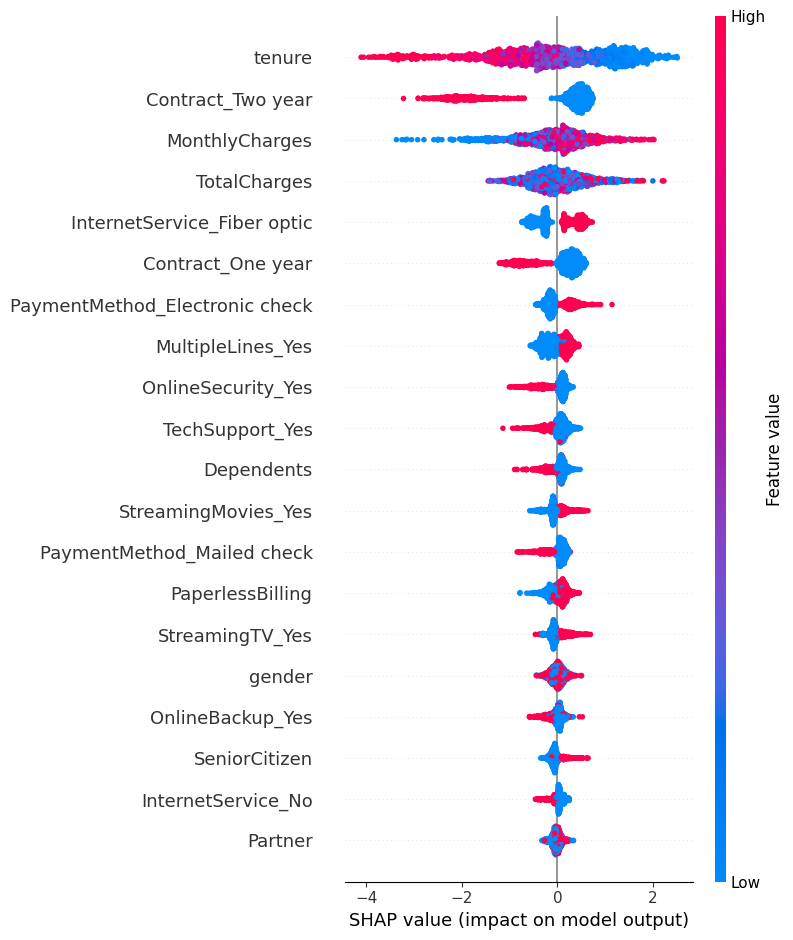

In [8]:
#SHAP Summary Plot

import shap

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test)

In [9]:
#SHAP Force Plot

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


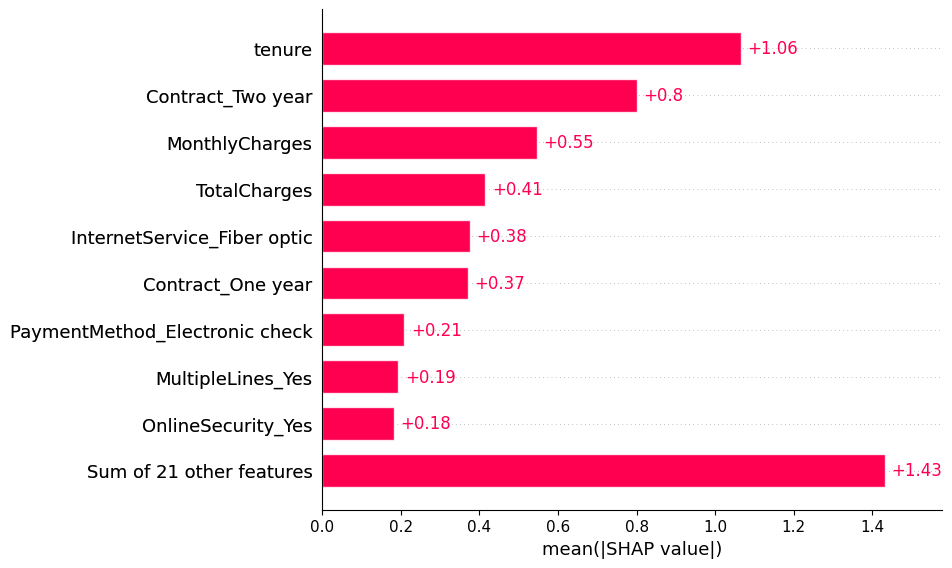

In [10]:
#SHAP Bar Plot

shap.plots.bar(shap_values)



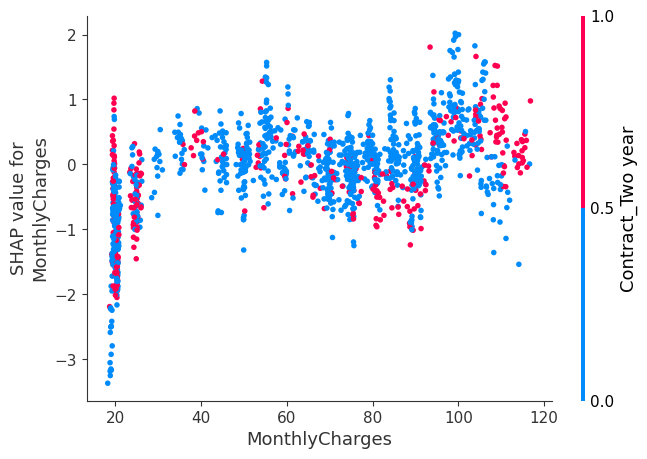

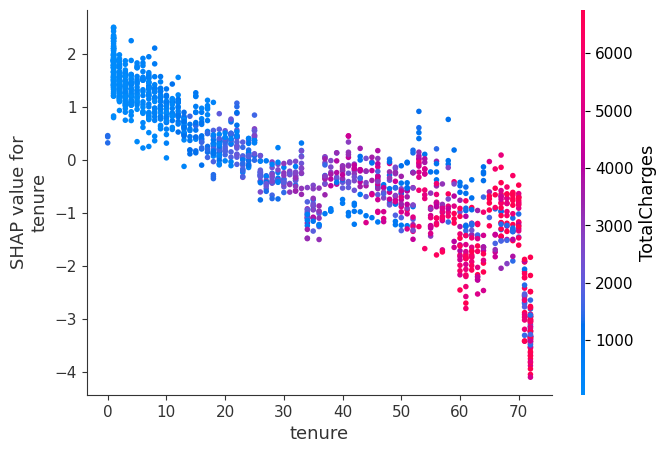

In [11]:
#SHAP Dependence Plot


# MonthlyCharges vs churn probability
shap.dependence_plot("MonthlyCharges", shap_values.values, X_test)

# Tenure vs churn probability
shap.dependence_plot("tenure", shap_values.values, X_test)


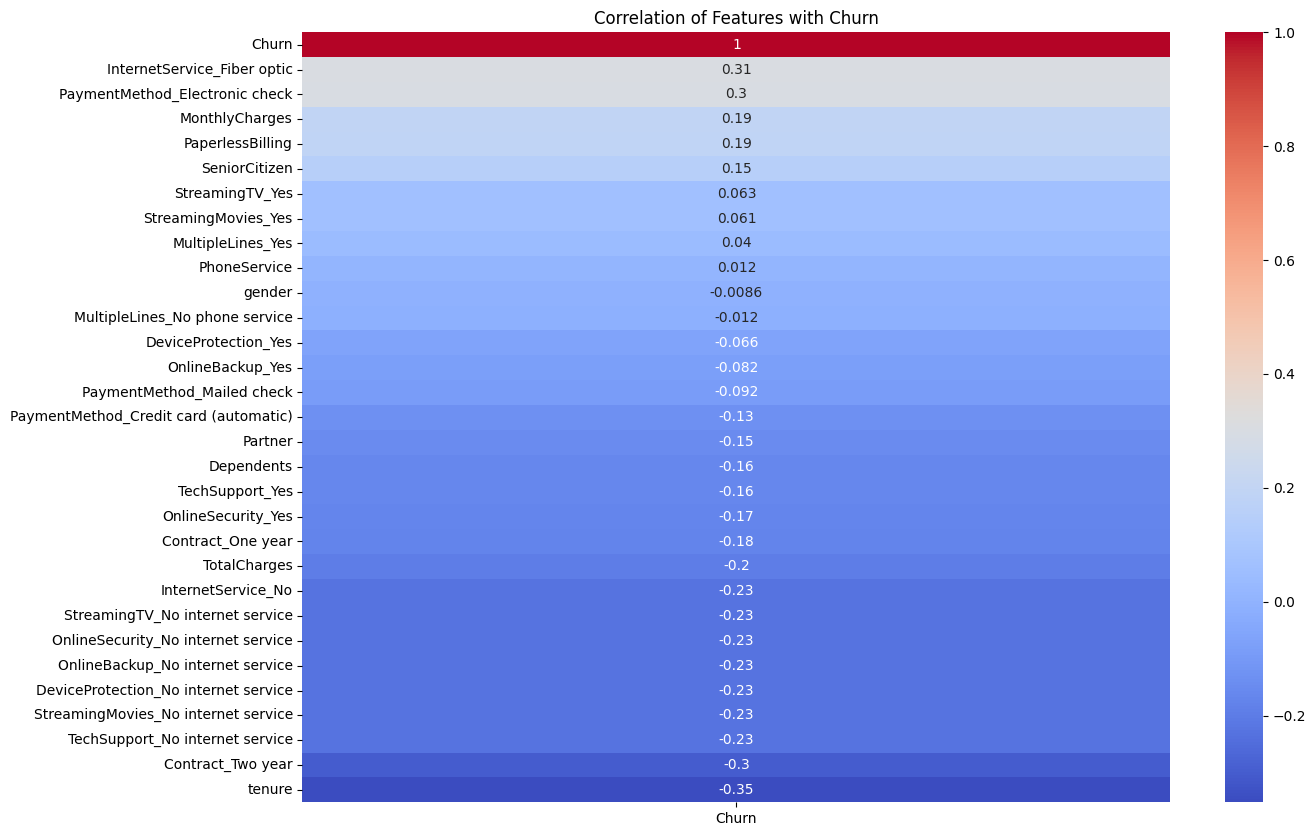

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add back target for correlation
df_corr = df.copy()

# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr()[['Churn']].sort_values(by='Churn', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Churn")
plt.show()


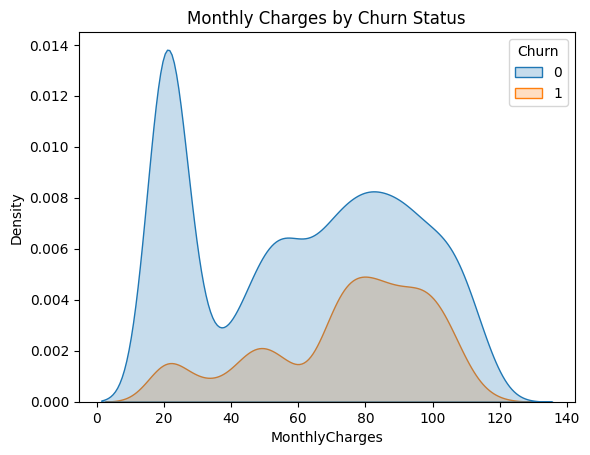

In [13]:
#kernel density estimation (KDE) plot
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Monthly Charges by Churn Status')
plt.show()


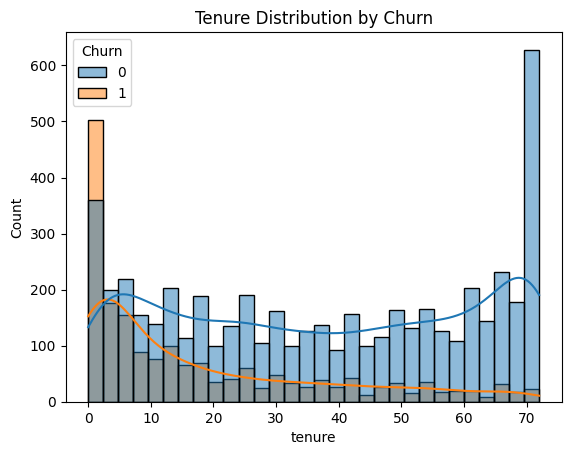

In [14]:
#Histogram Plot
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Tenure Distribution by Churn')
plt.show()


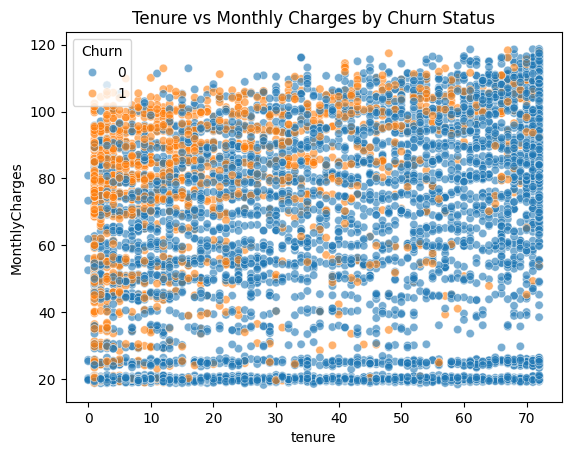

In [15]:
# 8. 2D Scatter: Tenure vs Monthly Charges by Churn
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.6)
plt.title('Tenure vs Monthly Charges by Churn Status')
plt.show()
